# IMDb Rating Predicition


## Inhaltsverzeichnis
### 1. Unsere Idee
### 2. Die IMDb Datenbank
### 3. Auswahl der Daten
### 4. Formatierung der Daten
### 5. Ergebnisse
### 6. Fazit

## Unsere Idee
Filme sind in der heutigen Zeit aus der Unterhaltungsbranche nicht wegzudenken. Mittlerweile werden durch verschiedene Streaminganbieter eine große Auswahl an Filmen angeboten, die jederzeit geschaut werden können. Einige von den Filmen werden von der Allgemeinheit besser bewertet als andere. Doch woran liegt es, dass einige Filme eine bessere Bewertung von den Zuschauern bekommen? Wir sind ebenfalls große Filmliebhaber. Deswegen haben wir uns gefragt, ob möglicherweise einige Faktoren wie zum Beispiel der Regisseur oder der Schauspieler einen Hinweis darauf liefern können, wie gut ein Film voraussichtlich von der Allgemeinheit bewertet wird.

Deswegen wollen wir mit diesem Projekt herausfinden, ob eine Korrelation zwischen den verschiedenen Daten eines Filmes und der durchschnittlichen Bewertung dessen vorliegt. Falls eine Korrelation besteht, könnte beispielsweise durch die Angabe der Schauspieler, die im Film mit spielen, die durchschnittliche Bewertung des Films hervorgesagt werden. Dadurch wäre es in Zukunft unter anderem möglich zu schauen, welche Schauspieler zusammen einen voraussichtlich guten Film und welche einen eher nicht so gut bewerteten Film drehen würden. Hierbei ist es wichtig herauszufinden, ob und welche Filmdaten überhaupt einen Einfluss auf die Bewertung haben. Außerdem ist die Auswahl eines guten Datensets wichtig, um die Idee mit Hilfe von Machine Learning umsetzen zu können.

## Die IMDb Datenbank
Bei der Auswahl des Datensets wurde sich für die IMDb (Internet Movie Database) Datenbank entschieden, da diese die größte öffentlich zugängliche Filmdatenbank ist. In dieser Datenbank können verschiedene Daten zu den Filmen sowie den Personen, die am Film mitgewirkt haben, gefunden werden.
Ein ausgewählter Teil der IMDb Datenbank kann beispielsweise auf Kaggle gefunden werden.
Es handelt sich dabei um eine relationale Datenbank, welche folgende Tabellen enthält:


In [1]:
%load_ext autoreload
%reload_ext autoreload
#%matplotlib inline
import database_connector
import main
db = database_connector.DataBase()
tables = db.show_tables()

for table in tables:
    field_info_text = db.get_table_field_info(table)

    print(f"Spalten der Tabelle {table}:")
    print("\n".join(field_info_text))
    print("\n")


Spalten der Tabelle most_rated_movies:
primaryTitle: VAR_STRING 
numVotes: LONG NUMERIC


Spalten der Tabelle person:
nconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
primaryName: VAR_STRING 
birthYear: LONG NUMERIC
deathYear: LONG NUMERIC
primaryProfession: VAR_STRING 
knownForTitles: VAR_STRING 
averageRating: DOUBLE NUMERIC


Spalten der Tabelle titleakas:
titleId: STRING NOT_NULL | NO_DEFAULT
ordering: LONG NOT_NULL | NUMERIC
title: VAR_STRING 
region: STRING 
language: STRING 
types: VAR_STRING 
attributes: VAR_STRING 
isOriginalTitle: LONG NUMERIC


Spalten der Tabelle titlebasic:
tconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
titleType: VAR_STRING 
primaryTitle: VAR_STRING 
originalTitle: VAR_STRING 
isAdult: LONG NUMERIC
startYear: LONG NUMERIC
endYear: LONG NUMERIC
runtimeMinutes: LONG NUMERIC
genres: VAR_STRING 


Spalten der Tabelle titleprincipals:
tconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFAULT
ordering: LONG NUMERIC
nconst: STRING NOT_NULL | PRIMARY_KEY | NO_DEFA

Viele Einträge sind allerdings fehlerhaft oder unvollständig, weswegen es wichtig ist, diese zu filtern und nur die relevanten Daten zu verwenden.

Die Tabelle Titlebasic beinhaltet alle Titel und ist 5 Millionen Einträge groß:

In [2]:
db.sql("SELECT COUNT(*) FROM titlebasic")[0]

(5701079,)

Die IMDb Datenbank enthält allerdings nicht nur Daten zu Filmen, sondern auch zu Serien. Deswegen müssen die 5 Millionen Einträge nach dem Typ Film gefiltert werden. Dadurch kommen wir auf ungefähr 500.000 Einträge:

In [3]:
db.sql("SELECT COUNT(*) FROM titlebasic WHERE titleType = 'Movie'")[0]

(509332,)

Unter diesen 500.000 Filmen sind einige, die keine Bewertung haben. Diese müssen ebenfalls herausgefiltert werden, wodurch 200.000 Einträge übrig bleiben:


In [4]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie'")[0]

(237738,)

Davon haben nur 3000 Einträge mehr als 50000 Bewertungen, ein Wert bei welchem wir festgestellt haben, dass die Bewertungen eine ausreichende Aussagekraft besitzen.

In [5]:
db.sql("SELECT COUNT(*) FROM titlebasic inner join titleratings on titleratings.tconst = titlebasic.tconst where titleType = 'Movie' AND titleratings.numVotes > 50000")[0]


(3023,)

Das sind die Filme, die in der view "Valid_Movies" dargestellt werden.

In [6]:
db.sql("SELECT primaryTitle, startYear, runtimeMinutes, genres FROM imdb.valid_movies order by startYear DESC limit 8")

[('The Pancake Ghost', 2021, 0, 'Musical'),
 ('Mayday', 2020, 0, 'Drama'),
 ('John Wick: Chapter 3 - Parabellum', 2019, 131, 'Action,Crime,Thriller'),
 ('Us', 2019, 116, 'Horror,Mystery,Thriller'),
 ('Shazam!', 2019, 132, 'Action,Adventure,Comedy'),
 ('Alita: Battle Angel', 2019, 122, 'Action,Adventure,Sci-Fi'),
 ('The Lion King', 2019, 118, 'Adventure,Animation,Drama'),
 ('Fast & Furious Presents: Hobbs & Shaw', 2019, 137, 'Action,Adventure')]

Wenn die View "Valid_Movies" nach der Bewertung sortiert wird fällt auf, dass die Liste der best bewertesten Filme auf der IMDb Website dieser ähnelt, weswegen davon ausgegangen werden kann, dass die IMDb ähnliche Filter anwendet.

In [7]:
db.get_top_rated_movies()

[('The Shawshank Redemption', 1994, 9.3, 2159745),
 ('The Godfather', 1972, 9.2, 1482225),
 ('The Godfather: Part II', 1974, 9.0, 1032110),
 ('The Dark Knight', 2008, 9.0, 2134602),
 ('The Mountain II', 2016, 9.0, 101817),
 ('12 Angry Men', 1957, 8.9, 617607),
 ("Schindler's List", 1993, 8.9, 1120297),
 ('Pulp Fiction', 1994, 8.9, 1695159),
 ('The Lord of the Rings: The Return of the King', 2003, 8.9, 1533632),
 ('The Good, the Bad and the Ugly', 1966, 8.8, 640941),
 ('Forrest Gump', 1994, 8.8, 1662609),
 ('The Lord of the Rings: The Fellowship of the Ring', 2001, 8.8, 1548920),
 ('Fight Club', 1999, 8.8, 1725444),
 ('Inception', 2010, 8.8, 1892958),
 ('Joker', 2019, 8.8, 466912),
 ("One Flew Over the Cuckoo's Nest", 1975, 8.7, 852798),
 ('Star Wars: Episode V - The Empire Strikes Back', 1980, 8.7, 1078754),
 ('Goodfellas', 1990, 8.7, 933687),
 ('The Matrix', 1999, 8.7, 1554345),
 ('The Lord of the Rings: The Two Towers', 2002, 8.7, 1387208),
 ("It's a Wonderful Life", 1946, 8.6, 36675

## Auswahl der Daten
Da wir nun die Auswahl der Datensätze getroffen haben, geht es nun darum, Attribute auszuwählen, die für das neurale Netzwerk genutzt werden können

In [8]:
movies = main.loadDataBase()
inception = movies[2213]
print(f"ID\t\t{inception.id}\nTitel\t\t{inception.title}\nJahr\t\t{inception.startYear}\nLaufzeit\t{inception.runtimeMinutes}\nGenres\t\t{inception.genres}\nAverage Rating\t{inception.averageRating}\nNumber of Votes\t{inception.numVotes}")

Loading Database...
100.0% 	 Time elapsed: 0:00:01.687s
Database loaded.
ID		tt1375666
Titel		Inception
Jahr		2010
Laufzeit	148
Genres		['Action', 'Adventure', 'Sci-Fi']
Average Rating	8.8
Number of Votes	1892958


Diese Daten bestimmen das Movie Objekt. Die meisten dieser Daten werden auch dem neuralen Netzwerk mitgegeben, einige dienen nur zur Information. Einem Movie gehören bis zu 10 "Mitarbeitern" an. Dazu zählen Schauspieler, Regisseure, Producer, Komponisten, etc.

In [9]:
crew = inception.actors
print("%-28s %-4s %20s" % ("Name", "Nummer", "Rolle  "))
for person in crew:
    print ("%-28s %-4s %20s" % (person.getName(),person.ordering,person.category))

Name                         Nummer              Rolle  
Leonardo DiCaprio            1                   actor
Joseph Gordon-Levitt         2                   actor
Ellen Page                   3                 actress
Ken Watanabe                 4                   actor
Christopher Nolan            5                director
Emma Thomas                  6                producer
Hans Zimmer                  7                composer
Wally Pfister                8         cinematographer
Lee Smith                    9                  editor
Guy Hendrix Dyas             10    production_designer


Name ist dabei eigentlich "ID", hier aber zur besseren Lesbarkeit als Name dargestellt. <br>
Von den kombinierten Tabellen "person" und "titleprincipals" sind dies die daten, die sinnvoll sind. <br>
Nun ist die Frage, welche der Attribute von Movie und Actor für die Ermittlung des Scores wichtig sind. <br>

Da stellt sich die Frage, welcher dieser Attribute den Score beeinflussen.<br>
Zunächst wurden dabei die Attribute `title`,`startYear`,`runtime`, `genre` und `actor` geeinigt, wobei bei actor die attribute `nconst` (id), `ordering` (nummer) und `category` (Rolle) beinhaltet. Diese Attribute unterscheiden einen Film, können jedoch auch gleichzeitig in mehreren Filmen gleich sein, was eine voraussetzung für das lernen ist. Je mehr gleiche Attribute, desto einfacher kann das neurale Netzwerk lernen.
Attribute wie die ID eines Films machen keinen Sinn, da sich diese niemals im Datensatz wiederholen, beim Titel wird deshalb nur die Länge des Titels und nicht der eigentliche Titel verwendet.

## Formatierung der Daten
Nachdem die Daten aus der Datenbank in das Python Programm geladen wurden, liegen sie als Objekte im Speicher. Da die ausgesuchten Algorithmen keine relationalen Objektdaten verarbeiten können, müssen diese in Vektoren eiener konstanten Dimension umformatiert werden. Die einschränkungen des IMDb Datensatzes kamen uns dabei entgegen. <br>
Das größte Problem war dabei die umkonvertierung der kategorischen Daten zu numerischen Werten. Die Werte `startYear`, `runtime`, `numberOfVotes` und (Länge des) `title` waren schon numerisch, weshalb diese direkt in den Vektor aufgenommen werden können.



## Ergebnisse

Mit den oben genannten Attributen ein MLPClassifier von Scikit learn trainiert. Dieser versucht anhand von verschiedenen Attributen den Film in eine Klasse einzuordnen. Die Klassen sind dabei verschiedene Ratings, in ganze Zahlen konvertiert um die Vorhersagen etwas einfacher zu machen. Hier lagen anfangs die Test Scores bei etwa 50%.
Jedoch wurde bei manuellen Tests klar, dass der Classifier sehr konservative Ratings vorhersagt, die in der Regel zwischen fünf und sieben Sternen lagen. Dadurch könnte der Test Score allein durch konservatives raten so hoch sein.

Hier stellte sich die Frage, warum der Classifier so "vorsichtig" rät. Die Vermutung bestand, dass der Classifier <br>
* nicht genügend Daten pro Film hat,
* mit den Daten des Films nichts anfangen kann,
* oder zwischen den Daten und dem Rating des Films kein Zusammenhang besteht.

Um der ersten Vermutung nachzugehen wurde außerdem die Anzahl der Ratings als Attribut mitgegeben. Damit erhöhte sich der Test Score allerdings nur geringfügig.

Um der zweiten Vermutung nachzugehen, könnte anstatt eines Schauspielers die durchschnittliche Bewertung aller Filme mitgegeben werden, an denen dieser partizipiert hat.
Hiermit steigerte sich der Score auf etwa 75%. Auch wurde mit einem decision Tree anstatt einem neuralen Netzwerk getestet, hier gab es ähnliche Scores, wobei hier teils geringere Ladezeiten aufgetreten sind.
Beim lernen kann deshalb entschieden werden, ob ein neurales Netzwerk genutzt werden soll oder ob der decision Tree genutzt werden soll.

### Der Predictor
Zunächst werden alle Filme aus der Datenbank geladen.

In [10]:
import database_connector
import ratingPredictor

allMovies = main.loadDataBase()

Loading Database...
100.0% 	 Time elapsed: 0:00:01.627s
Database loaded.


Nun wird der Rating Predictor, also unser Decision Tree/Neurales Netwerk erzeugt und trainiert sich an den Daten allMovies.

In [11]:
rater = ratingPredictor.ratingPredictor(allMovies)
#rater.printallmovies()
neuralnetwork = False
clf = rater.learn(neuralnetwork) #Mit neural Network = True wird ein neurales Netzwerk genutzt anstatt der decision tree

Converting data...
100.0% 	 Time elapsed: 0:00:09.056s
Data converted.
Training started...
Training done.
Test score is:
0.75303197353914


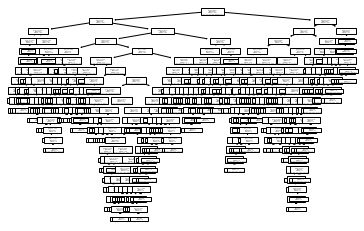

In [14]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from sklearn import tree
if neuralnetwork:
    plt.plot(clf.loss_curve_)
else:
    tree.plot_tree(clf)

<BarContainer object of 9 artists>

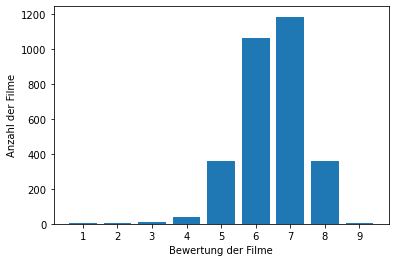

In [15]:
plt.ylabel('Anzahl der Filme')
plt.xlabel('Bewertung der Filme')
x = [1,2,3,4,5,6,7,8,9]
plt.xticks(x)
x, y = rater.plot_ratings()
plt.bar(x,y)

Text(0.5, 1.0, 'Confusion Matrix')

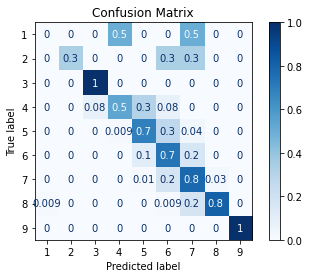

In [16]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
#disp = plot_roc_curve(clf, rater.x_test, rater.y_test)
disp = plot_confusion_matrix(clf, rater.x_test, rater.y_test,
                                 display_labels=[1,2,3,4,5,6,7,8,9],
                                 cmap='Blues',
                                 normalize='true',
                                values_format='.0g')
disp.ax_.set_title('Confusion Matrix')

In [17]:
from sklearn.metrics import classification_report
y_pred, y_true = rater.predictAllTestValues()
print(classification_report(y_true, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.33      0.50         3
           3       0.50      1.00      0.67         1
           4       0.78      0.54      0.64        13
           5       0.65      0.69      0.67       109
           6       0.69      0.73      0.71       298
           7       0.80      0.78      0.79       370
           8       0.89      0.81      0.85       110
           9       1.00      1.00      1.00         1

    accuracy                           0.75       907
   macro avg       0.70      0.65      0.65       907
weighted avg       0.76      0.75      0.75       907



In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(rater.y_test,clf.predict_proba(rater.x_test),multi_class='ovr')

0.8069952022309798

### DIY
Nun kann dieser RatingPredictor auch Bewertungen von Filmen vorhersagen. Dazu können wir uns anschauen, welche Möglichkeiten wir haben, einen Film zu erstellen.

In [ ]:
rater.getAllRoles()

Dies sind alle Rollen, die ein Schauspieler/Crew haben kann. Diese müssen auch genau so geschrieben werden, damit sie erkannt werden.

In [ ]:
rater.getAllGenres()

Dies sind alle Genres, die ein Film haben kann. Ein Film kann bis zu drei Genres haben, braucht jedoch nur eins.

Ein Film kann nach dem Schema (Titel(String), Veröffentlichungsjahr(int), Laufzeit(int), Genre1(String), Genre2(String), Genre3(String), Anzahl der Bewertungen(int)) erzeugt werden. Anschließend können schauspieler mit der Funktion `addCrewByName` hinzugefügt werden, mit dem Schema (Name(String), Rolle(String))

In [ ]:
newMovie = main.createMovie("Mein neuer Film",2000,120,"Action","Crime","War",100000)
newMovie.addCrewByName("Johnny Depp", "actor")
newMovie.addCrewByName("Christian Bale", "actor")
newMovie.addCrewByName("Michael Bay","director")
newMovie.addCrewByName("John Williams", "composer")
newMovie.getAsString()

Nun kann der RatingPredictor das Rating vorhersagen

In [ ]:
rater.predictMovie(newMovie)

Fazit: Filmnamelänge: Kurz eher schlechter, länger eher besser
       Jahr: Kaum auswirkungen, außer in extrembereichen
       Fimlänge: Kaum auswirkungen
       Anzahl der Bewertungen: Je mehr, desto besser
       
        

In [ ]:
fig, axes = plt.subplots(1, 16)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = clf.coefs_[0].min(), clf.coefs_[0].max()
for coef, ax in zip(clf.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(157,1), cmap='Blues', vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()